#### The implementation of a sequential hybrid anomaly detection model using Isolation Forest and SVM begins by loading and cleaning your data. Then, select crucial features and split the data into training and testing sets. Standardize the features to ensure a uniform scale. First, fit an Isolation Forest to isolate potential anomalies quickly, followed by an SVM to refine anomaly detection with a precise classification boundary. Evaluate the model's performance using precision, recall, F1-score, and a confusion matrix to assess accuracy and sensitivity. This method combines the strengths of both models for robust anomaly detection.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder

Precision: 0.996
Recall: 0.996
F1 Score: 0.996
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5323
           1       1.00      0.99      1.00      4677

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



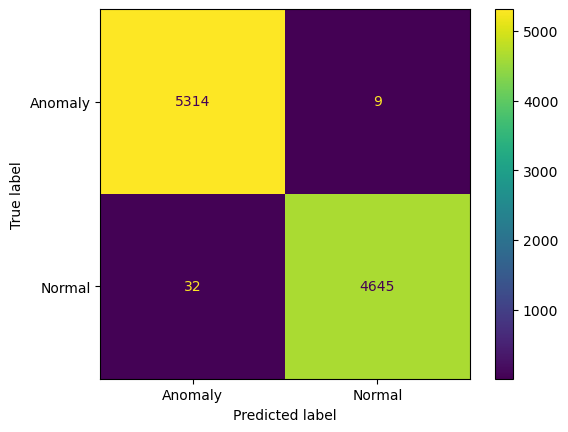

In [6]:

def hybrid_iso_svm():
    # Load the dataset
    
    data1 = pd.read_csv('MetroPT3.csv')
    
    data = data1.sample(n=50000, random_state=5)
    
    data = data.drop(['timestamp'], axis=1)
    data.dropna(axis=0, inplace=True)

    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
        
#     data.info()
    
    # Preprocessing
#     scaler = StandardScaler()
#     data_scaled = scaler.fit_transform(data)
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
    
    X = data.drop('Reservoirs', axis=1)  # Assuming 'label' is your target column
    y_cont = data['Reservoirs']

    # First, binarize `y` based on a chosen threshold.
    y = np.where(y_cont > 9, 1, 0)  # Define `threshold` based on the dataset

    # Select top k features; you might adjust k based on your dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    # Use Isolation Forest to identify normal data points
    iso_forest = IsolationForest(contamination=0.1, n_estimators=100, random_state=42)
    iso_forest.fit(X_train_scaled)
    iso_preds = iso_forest.predict(X_train_scaled)
    
    # Append Isolation Forest predictions as a new feature to the scaled data
    X_train_scaled_with_pred = np.hstack((X_train_scaled, iso_preds.reshape(-1, 1)))
    
    # Filter only normal data points as identified by Isolation Forest
    normal_indices = np.where(iso_preds == 1)[0]  # Assuming '1' is normal
    X_train_normal = X_train_scaled[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    # Train SVM on the filtered normal data
    svm = SVC(kernel='rbf', gamma='auto')
    svm.fit(X_train_normal, y_train_normal)
    
    # Prepare test data by appending Isolation Forest predictions
    iso_preds_test = iso_forest.predict(X_test_scaled)
    X_test_scaled_with_pred = np.hstack((X_test_scaled, iso_preds_test.reshape(-1, 1)))
    
    # Predict using SVM on the test set
    svm_preds = svm.predict(X_test_scaled_with_pred[:, :-1])  # Exclude the appended Isolation Forest predictions
    
    # Evaluate the final outcome from SVM
    precision = precision_score(y_test, svm_preds, average='weighted', zero_division=0)
    recall = recall_score(y_test, svm_preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, svm_preds, average='weighted', zero_division=0)
    
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')
    
    
    print(classification_report(y_test, svm_preds))
    
    
    # Use a confusion matrix for visualization of the outcome
    
    cm = confusion_matrix(y_test, svm_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()


hybrid_iso_svm()